In [61]:
import sys
sys.path.append("../")

In [62]:
import gc
import joblib
import lightgbm as lgb
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import optuna
import pandas as pd
import plotly.express as px
import seaborn as sns
import time

from datetime import datetime
from itertools import combinations, groupby, product
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [63]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import (
    Dense, Input, Reshape, concatenate, Lambda, Concatenate, Dropout, BatchNormalization, 
    LSTM, GRU, Bidirectional, Conv1D, ConvLSTM1D, TimeDistributed, Flatten
)
print('Using TensorFlow version',tf.__version__)

Using TensorFlow version 2.14.0


In [64]:
from common_utils import (
    cprint, get_cols, my_concat, check_memory_usage, plot_feature_importance, my_power, my_log, list_diff, zero_sum
)

In [65]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
DATA_DIR = '../data'

In [67]:
%%time
train = pd.read_parquet(f'{DATA_DIR}/optiver-train-data/raw_train.parquet')

CPU times: user 252 ms, sys: 150 ms, total: 401 ms
Wall time: 80.9 ms


# Preprocessing

## Simple Cleaning

In [68]:
def clean_df(df):
    df = df.drop(columns=['row_id', 'time_id'], errors="ignore")
    df = df.rename(
        columns={
            "seconds_in_bucket": "seconds",
            "imbalance_size": "imb_size",
            "imbalance_buy_sell_flag": "imb_flag",
            "reference_price": "ref_price",
            "wap": "wa_price", 
        }
    )
    return df

In [69]:
train = clean_df(train)

## Clipping

Can update this clipping logic
- To by group clipping instead of global clipping, because some stock might be always nearer to the clipping bound, while some are not
- By defining the bound using outlier factor instead of simple percentile

In [70]:
PRICE_CLIP_PERCENTILE = 0.01 # 1 - (2 * PRICE_CLIPPER_TAIL / 100) will remained unclip

In [71]:
def get_price_clippers(df, price_cols, price_clip_percentile=PRICE_CLIP_PERCENTILE):
    price_clippers = {}
    for price_col in price_cols:
        upper_bound = np.percentile(df[price_col].dropna(), 100 - price_clip_percentile)
        lower_bound = np.percentile(df[price_col].dropna(), price_clip_percentile)
        price_clippers[price_col] = (lower_bound, upper_bound)
        cprint(f"For {price_col}, the global clip bound is", end=" ", color="blue")
        cprint(f"({lower_bound:.4f}, {upper_bound:.4f})", color="green")
    return price_clippers

In [72]:
base_price_cols = get_cols(train, contains="price")
price_clippers = get_price_clippers(train, base_price_cols)

For ref_price, the global clip bound is (0.9798, 1.0246)
For far_price, the global clip bound is (0.7866, 1.3063)
For near_price, the global clip bound is (0.8942, 1.1092)
For bid_price, the global clip bound is (0.9793, 1.0223)
For ask_price, the global clip bound is (0.9814, 1.0249)
For wa_price, the global clip bound is (0.9802, 1.0233)


In [73]:
VOLUME_CLIPPER_UPPER_TAIL = 0.01 # only the top VOLUME_CLIPPER_UPPER_TAIL proportion will be clipped

In [74]:
def get_volume_clippers(df, volume_cols, volume_clip_upper_percentile=VOLUME_CLIPPER_UPPER_TAIL):
    volume_clippers = {}
    for volume_col in volume_cols:
        upper_bound = np.percentile(df[volume_col].dropna(), 100 - volume_clip_upper_percentile)
        volume_clippers[volume_col] = (0, upper_bound)
        cprint(f"For {volume_col}, the global clip bound is", end=" ", color="blue")
        cprint(f"(0, {upper_bound:.4f})", color="green")
    return volume_clippers

In [75]:
base_volume_cols = get_cols(train, contains="size")
volume_clippers = get_volume_clippers(train, base_volume_cols)

For imb_size, the global clip bound is (0, 587222572.7743)
For matched_size, the global clip bound is (0, 4502560423.2681)
For bid_size, the global clip bound is (0, 2392089.1659)
For ask_size, the global clip bound is (0, 2754727.0502)


In [76]:
PRICE_MULTIPLIER = 10 # Factor to multiple the price col after taking the distance to 1
PRICE_POWER_FACTOR = 1/2 # Factor to transform the price col to bimodal distribution, the lower the further apart of the modes

In [77]:
MIN_TARGET = -100
MAX_TARGET = 100

In [78]:
def clip(df, price_clippers=None, volume_clippers=None):
    # Find the column list for each group
    price_cols = get_cols(df, endswith="price")
    volume_cols = get_cols(df, endswith="size")
    flag_cols = get_cols(df, endswith="flag")
    base_cols = price_cols + volume_cols + flag_cols
    
    if price_clippers is None:
        price_clippers = get_price_clippers(df, price_cols)
    
    if volume_clippers is None:
        volume_clippers = get_volume_clippers(df, volume_cols)
    
    # Clip price columns
    for price_col in price_cols:
        df[price_col] = df[price_col].clip(*price_clippers[price_col])
        
    # Clip volume columns
    for volume_col in volume_cols:
        df[volume_col] = df[volume_col].clip(*volume_clippers[volume_col])
    
    # Clip target columns (if applicable)
    if "target" in df.columns:
        df["clipped_target"] = df["target"].clip(MIN_TARGET, MAX_TARGET)
        df["binary_target"] = (df["target"] > 0).astype(int)
    return df

In [79]:
%%time
train = clip(train, price_clippers=price_clippers, volume_clippers=volume_clippers)

CPU times: user 205 ms, sys: 186 ms, total: 391 ms
Wall time: 388 ms


## Merge Additional Data

In [80]:
%%time
weight_df = pd.read_csv(f"{DATA_DIR}/optiver-train-data/stock_weight.csv")
median_vol = pd.read_csv(f"{DATA_DIR}/optiver-memoryreduceddatasets/MedianVolV2.csv")
median_vol.index.name = "stock_id"
median_vol = median_vol[['overall_medvol', "first5min_medvol", "last5min_medvol"]]

CPU times: user 6.13 ms, sys: 3.97 ms, total: 10.1 ms
Wall time: 8.77 ms


In [81]:
%%time
train = train.sort_values(by=["stock_id", "date_id", "seconds"]).reset_index(drop=True)
prev_day_target_stats = train.groupby(["stock_id", "date_id"])["target"].agg(["mean", "std", "min", "median", "max"])
prev_day_target_stats = prev_day_target_stats.groupby("stock_id").shift(1).add_prefix("ytd_target_").reset_index()

CPU times: user 1.37 s, sys: 475 ms, total: 1.85 s
Wall time: 2.11 s


In [82]:
train = train.sort_values(by=["stock_id", "seconds", "date_id"]).reset_index(drop=True)
train["ytd_target_at_s"] = train.groupby(["stock_id", "seconds"])["target"].shift(1)

In [83]:
train = train.sort_values(by=["stock_id", "date_id", "seconds"]).reset_index(drop=True)

In [84]:
def merge_additional_info(df, pdts=prev_day_target_stats):
    # Merge additional static information
    df = df.merge(weight_df, on="stock_id", how="left")
    df = df.merge(median_vol, left_on="stock_id", right_index=True, how="left")
    
    # Merge additional dynamic information
    df = df.merge(pdts, on=["stock_id", "date_id"], how="left")
    return df

In [85]:
%%time
train = merge_additional_info(train)

CPU times: user 551 ms, sys: 574 ms, total: 1.12 s
Wall time: 1.24 s


## Remove standard base price columns == NaN 的 Stock ID x Date ID pairs

In [87]:
standard_base_price_cols = ["bid_price", "ask_price", "wa_price", "ref_price"]

In [88]:
missing_stock_dates = train.loc[train[standard_base_price_cols[0]].isnull()].drop_duplicates(subset=["stock_id", "date_id"])
missing_stock_dates

,stock_id,date_id,seconds,imb_size,imb_flag,ref_price,matched_size,far_price,near_price,bid_price,...,ytd_target_at_s,weight,overall_medvol,first5min_medvol,last5min_medvol,ytd_target_mean,ytd_target_std,ytd_target_min,ytd_target_median,ytd_target_max
526735,19,438,0,NaN,-1,NaN,NaN,NaN,NaN,NaN,...,2.820492,0.002,32095.83,24543.965,40962.880,3.315633,11.044415,-27.539730,5.639791,20.890236
2677675,101,328,0,NaN,0,NaN,NaN,NaN,NaN,NaN,...,11.999607,0.002,39926.52,28550.580,69507.745,3.376516,6.725093,-9.970069,3.000498,14.920235
3438985,131,35,0,NaN,0,NaN,NaN,NaN,NaN,NaN,...,10.670424,0.002,33607.86,25734.000,52067.140,-2.908533,9.818639,-25.169849,-3.409982,16.859770
4153050,158,388,0,NaN,0,NaN,NaN,NaN,NaN,NaN,...,-12.099743,0.001,21111.52,16733.820,28503.260,3.834757,11.792637,-21.229982,3.670454,28.729439


In [89]:
index_to_drop = []
for stock_id, date_id in zip(missing_stock_dates["stock_id"], missing_stock_dates["date_id"]):
    index_to_drop.extend(train.loc[(train["stock_id"] == stock_id) & (train["date_id"] == date_id)].index.tolist())

In [90]:
len(index_to_drop)

220

In [91]:
train = train.drop(index=index_to_drop).reset_index(drop=True)

## Scale base price / volume columns to better range / unit

In [92]:
train = train.sort_values(by=["stock_id", "date_id", "seconds"]).reset_index(drop=True)

# Make all the price columns centered at 0
train[get_cols(train, "price")] = train[get_cols(train, "price")] - 1

# Convert all volume columns to log(unit)
train[get_cols(train, "size")] = train[get_cols(train, "size")].apply(np.log1p)

# Scale all volume columns to the range of approximately 0 to 1
train["matched_size"] /= 20
train["imb_size"] /= 20
train["bid_size"] /= 15
train["ask_size"] /= 15

In [93]:
# pd.Series(my_log(train["target"])).plot.hist(bins=100)

In [94]:

# train = pd.read_parquet("../interim_data/train.parquet")

In [99]:
window_size = 11

In [100]:
temporal_columns = get_cols(train, contains=["price", "size", "flag", "at_s"], excludes=["far", "near"])
temporal_columns

['imb_size',
 'imb_flag',
 'ref_price',
 'matched_size',
 'bid_price',
 'bid_size',
 'ask_price',
 'ask_size',
 'wa_price',
 'ytd_target_at_s']

In [101]:
# Get sequence input into dataframe
master_list = []
for col in tqdm(temporal_columns):
    temp_list = []
    for i, window in enumerate(train.groupby(["stock_id", "date_id"]).rolling(window=window_size)):
        temp_list.append(window[col].to_numpy())
    # master_list.append(temp_list)
    train[f"temporal_w{window_size}_" + col] = temp_list

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [19:07<00:00, 114.72s/it]


In [102]:
train.shape

(5237760, 37)

In [103]:
train.to_parquet("../interim_data/train_w11.parquet")

In [104]:
# train = train.loc[train["seconds"] >= window_size * 10].reset_index(drop=True)
train = train.loc[train["seconds"] >= window_size * 10].reset_index(drop=True)

In [105]:
gc.collect()

426

In [106]:
train.shape

(4190208, 37)

In [107]:
temporal_bid_ask_volume_columns = get_cols(train, startswith="temporal", contains=["bid", "ask"], endswith="size")
temporal_match_imb_volume_columns = get_cols(train, startswith="temporal", contains=["matched", "imb"], endswith="size")
temporal_bid_ask_price_columns = get_cols(train, startswith="temporal", contains=["bid", "ask"], endswith="price")
temporal_ref_wa_price_columns = get_cols(train, startswith="temporal", contains=["ref", "wa"], endswith="price")
temporal_ytd_target_columns = get_cols(train, startswith="temporal", contains=["ytd"], endswith="at_s")
temporal_flag_columns = get_cols(train, startswith="temporal", endswith="flag")

In [108]:
temporal_bid_ask_volume_inputs = Input(shape=(window_size, len(temporal_bid_ask_volume_columns)), name="BidAskVolumeWindowInputs")
temporal_match_imb_volume_inputs = Input(shape=(window_size, len(temporal_match_imb_volume_columns)), name="MatchImbVolumeWindowInputs")
temporal_bid_ask_price_inputs = Input(shape=(window_size, len(temporal_bid_ask_price_columns)), name="BidAskPriceWindowInputs")
temporal_ref_wa_price_inputs = Input(shape=(window_size, len(temporal_ref_wa_price_columns)), name="WARefPriceWindowInputs")
temporal_ytd_target_inputs = Input(shape=(window_size, len(temporal_ytd_target_columns)), name="YtdTargetWindowInputs")
temporal_flag_inputs = Input(shape=(window_size, len(temporal_flag_columns)), name="FlagWindowInput")
fc_inputs = Input(shape=(len(final_dense_input_columns)), name="DenseInputs")

In [109]:
EPOCHS = 12
BATCH_SIZE = 64
LR_MAX = 1e-4
LR_MIN = 1e-6
VERBOSE = 1
N_SPLITS = 5

In [110]:
LR = ReduceLROnPlateau(
    monitor=f"val_mae", 
    factor=0.75, 
    patience=2, 
    verbose=1
)

In [111]:
def lr_scheduler(epoch, current_learning_rate):
    if epoch < 3:
        return current_learning_rate  # Keep the initial learning rate for the first 10 epochs
    else:
        return current_learning_rate * tf.math.exp(-0.2)  # Reduce the learning rate exponentially

In [112]:
LR2 = LearningRateScheduler(lr_scheduler, verbose=1)

In [113]:
ES = EarlyStopping(
    monitor='val_mae', 
    min_delta=1e-6,     # an absolute change of less than min_delta, will count as no improvement.
    patience=4,         # Number of epochs with no improvement after which training will be stopped.
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True
)

In [114]:
def cnn_rnn_block1(seq_inputs, padding="same"):
    conv1d_3 = Conv1D(filters=16, kernel_size=3, activation="relu", padding=padding)(seq_inputs)
    conv1d_5 = Conv1D(filters=16, kernel_size=5, activation="relu", padding=padding)(seq_inputs)
    conv1d_7 = Conv1D(filters=8, kernel_size=7, activation="relu", padding=padding)(seq_inputs)
    conv1d_output = Concatenate()(
        [conv1d_3, conv1d_5, conv1d_7]
    )
    gru = GRU(units=16, activation="tanh", return_sequences=True)(conv1d_output)
    # lstm = LSTM(units=16, activation="tanh", return_sequences=True)(conv1d_3)
    # seq_outputs = Concatenate()([gru, lstm])
    return gru

In [115]:
def cnn_rnn_block2(seq_inputs, padding="same"):
    conv1d_3 = Conv1D(filters=4, kernel_size=3, padding=padding)(seq_inputs)
    gru = GRU(units=4, activation="tanh", return_sequences=True)(conv1d_3)
    # lstm = LSTM(units=128, activation="tanh", return_sequences=False)(conv1d_3)
    # seq_outputs = Concatenate()([gru, lstm])
    return gru

In [116]:
def my_mlp(concat_inputs):
    final_outputs = Dense(256, activation='swish')(concat_inputs)
    # final_outputs = BatchNormalization()(final_outputs)
    final_outputs = Dense(128, activation='selu')(final_outputs)
    # final_outputs = BatchNormalization()(final_outputs)
    final_outputs = Dense(1, activation='linear')(final_outputs)
    return final_outputs

In [119]:
def final_model(seq_inputs):
    bid_ask_volumes, match_imb_volumes, bid_ask_prices, ref_wa_prices, ytd_targets, flags = seq_inputs
    bid_ask_volumes = cnn_rnn_block1(bid_ask_volumes)
    bid_ask_prices = cnn_rnn_block1(bid_ask_prices)
    match_imb_volumes = cnn_rnn_block1(match_imb_volumes)
    ref_wa_prices = cnn_rnn_block1(ref_wa_prices)
    ytd_targets = cnn_rnn_block1(ytd_targets)
    flags = cnn_rnn_block2(flags)
    
    match_imb_volumes_with_flags = Concatenate(axis=2)(
        [match_imb_volumes, flags]
    )
    match_imb_volumes_with_flags = cnn_rnn_block1(match_imb_volumes_with_flags, padding="same")
    
    all_volumes = Concatenate(axis=2)(
        [match_imb_volumes_with_flags, bid_ask_volumes]
    )
    all_volumes = cnn_rnn_block1(all_volumes)
    
    bid_ask_everything = Concatenate(axis=2)(
        [bid_ask_prices, bid_ask_volumes]
    )
    bid_ask_everything = cnn_rnn_block1(bid_ask_everything)
    
    all_prices = Concatenate(axis=2)(
        [bid_ask_prices, ref_wa_prices]
    )
    all_prices = cnn_rnn_block1(all_prices)
    # Extract information from dense inputs 
    # fc_outputs = fc_extraction(fc_inputs)
    
    # Concatenate the seq_outputs and fc_outputs
    concat_inputs = Concatenate(axis=2)(
        [all_volumes, bid_ask_everything, all_prices, ytd_targets]
    )
    
    # concat_inputs = cnn_rnn_block1(concat_inputs)
    concat_inputs = Flatten()(concat_inputs)
    
    # concat_inputs = Concatenate()([concat_inputs, fc_inputs])
    
    # Predict final output using Multi-layer perceptron
    y_pred = my_mlp(concat_inputs)
    
    # define the model using the input and output layers
    model = Model(inputs=seq_inputs, outputs=y_pred)
    model.compile(loss="mae", optimizer=Adam(lr=LR_MAX), metrics=["mae"])
    return model

In [120]:
model = final_model(
    seq_inputs=[
        temporal_bid_ask_volume_inputs, temporal_match_imb_volume_inputs, temporal_bid_ask_price_inputs, temporal_ref_wa_price_inputs, temporal_ytd_target_inputs, temporal_flag_inputs
    ]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 MatchImbVolumeWindowInputs  [(None, 11, 2)]              0         []                            
  (InputLayer)                                                                                    
                                                                                                  
 conv1d_6 (Conv1D)           (None, 11, 16)               112       ['MatchImbVolumeWindowInputs[0
                                                                    ][0]']                        
                                                                                                  
 conv1d_7 (Conv1D)           (None, 11, 16)               176       ['MatchImbVolumeWindowInputs[0
                                                                    ][0]']                    

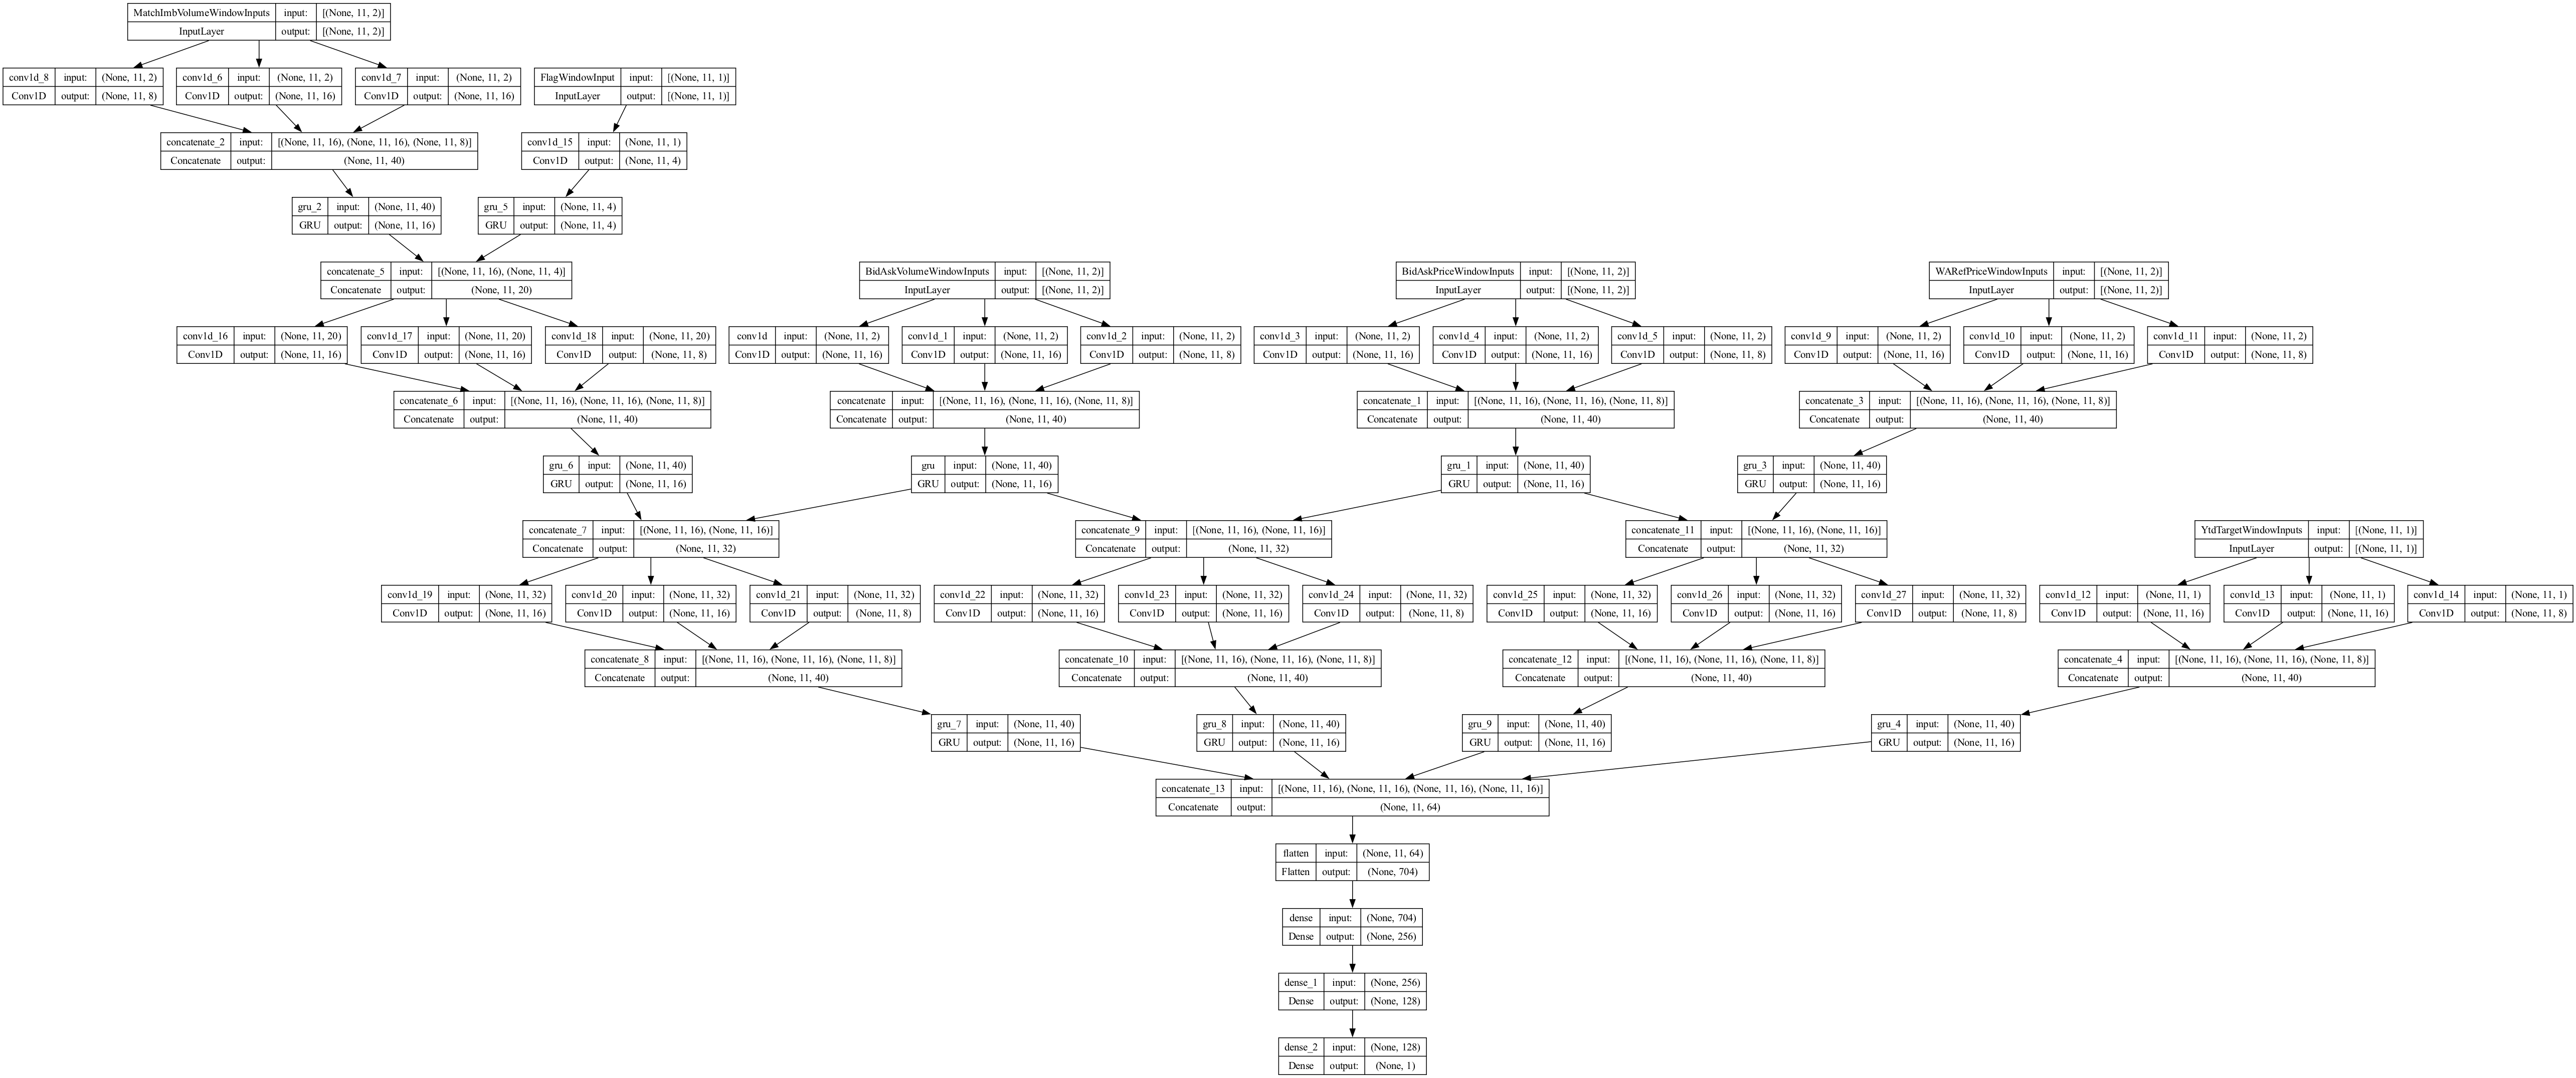

In [121]:
display(
    plot_model(
        model, 
        # to_file="../model_architecture_diagrams/model_architecture1.png",
        show_layer_names=True, 
        show_shapes=True, 
        dpi=108
    )
)

In [122]:
def stack_data_for_rnn(df, columns, input_window_size=window_size):
    return np.concatenate([np.stack(df[col].values) for col in columns], axis=1).reshape(-1, input_window_size, len(columns))

In [123]:
max_date_id = np.percentile(train["date_id"], 75)
max_date_id

361.0

In [124]:
tr = train.loc[train["date_id"].between(0, 420)]
va = train.loc[train["date_id"].between(421, 480)]

In [125]:
tr.shape, va.shape

((3662252, 37), (527956, 37))

In [128]:
%%time
column_groups = [
    temporal_bid_ask_volume_columns, temporal_match_imb_volume_columns, temporal_bid_ask_price_columns, temporal_ref_wa_price_columns, temporal_ytd_target_columns, temporal_flag_columns
]

tr_list, va_list = [], []
for input_data_list, data in zip([tr_list, va_list], [tr, va]):
    for column_group in column_groups:
        input_data_list.append(stack_data_for_rnn(data, column_group))

tr_tuples = tuple(tr_list)
va_tuples = tuple(va_list)

CPU times: user 14.1 s, sys: 4.07 s, total: 18.1 s
Wall time: 19.3 s


In [127]:
y_train = np.stack(tr["target"].values)
y_val = np.stack(va["target"].values)

In [129]:
checkpoint_path = "../models/keras/checkpoints/"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [130]:
n_batches = len(y_train) / BATCH_SIZE
n_batches = math.ceil(n_batches)

In [131]:
# Create a callback that saves the model's weights every 1 epochs
MC = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=False,
    save_best_only=True,
    save_freq=1*n_batches
)

In [132]:
%%time
h = model.fit(
    tr_tuples,
    y_train, 
    validation_data=(va_tuples, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS, 
    verbose=VERBOSE, 
    callbacks=[LR, LR2, ES, MC]
) 


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/12
10159/57223 [====>.........................] - ETA: 8:39 - loss: nan - mae: nan


KeyboardInterrupt



In [294]:
%%time
h = model.fit(
    tr_tuples,
    y_train, 
    validation_data=(va_tuples, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS, 
    verbose=VERBOSE, 
    callbacks=[LR, LR2, ES, MC]
) 


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/12
64167/64173 [============================>.] - ETA: 0s - loss: 6.4293 - mae: 6.4293
Epoch 1: saving model to ../models/keras/checkpoints/
INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


64173/64173 [==============================] - 594s 9ms/step - loss: 6.4292 - mae: 6.4292 - val_loss: 5.1591 - val_mae: 5.1591 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/12
64169/64173 [============================>.] - ETA: 0s - loss: 6.4150 - mae: 6.4150
Epoch 2: saving model to ../models/keras/checkpoints/
INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


64173/64173 [==============================] - 599s 9ms/step - loss: 6.4150 - mae: 6.4150 - val_loss: 5.1247 - val_mae: 5.1247 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/12
64171/64173 [============================>.] - ETA: 0s - loss: 6.4040 - mae: 6.4040
Epoch 3: saving model to ../models/keras/checkpoints/
INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


64173/64173 [==============================] - 714s 11ms/step - loss: 6.4040 - mae: 6.4040 - val_loss: 5.1119 - val_mae: 5.1119 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 8.187307685147971e-05.
Epoch 4/12
64172/64173 [============================>.] - ETA: 0s - loss: 6.3952 - mae: 6.3952
Epoch 4: saving model to ../models/keras/checkpoints/
INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


64173/64173 [==============================] - 840s 13ms/step - loss: 6.3951 - mae: 6.3951 - val_loss: 5.1069 - val_mae: 5.1069 - lr: 8.1873e-05

Epoch 5: LearningRateScheduler setting learning rate to 6.70320077915676e-05.
Epoch 5/12
64168/64173 [============================>.] - ETA: 0s - loss: 6.3894 - mae: 6.3894
Epoch 5: saving model to ../models/keras/checkpoints/
INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


64173/64173 [==============================] - 728s 11ms/step - loss: 6.3894 - mae: 6.3894 - val_loss: 5.0999 - val_mae: 5.0999 - lr: 6.7032e-05

Epoch 6: LearningRateScheduler setting learning rate to 5.488116585183889e-05.
Epoch 6/12
64168/64173 [============================>.] - ETA: 0s - loss: 6.3856 - mae: 6.3856
Epoch 6: saving model to ../models/keras/checkpoints/
INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


64173/64173 [==============================] - 594s 9ms/step - loss: 6.3856 - mae: 6.3856 - val_loss: 5.1035 - val_mae: 5.1035 - lr: 5.4881e-05

Epoch 7: LearningRateScheduler setting learning rate to 4.493289816309698e-05.
Epoch 7/12
64167/64173 [============================>.] - ETA: 0s - loss: 6.3825 - mae: 6.3825
Epoch 7: saving model to ../models/keras/checkpoints/
INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


64173/64173 [==============================] - 614s 10ms/step - loss: 6.3825 - mae: 6.3825 - val_loss: 5.0986 - val_mae: 5.0986 - lr: 4.4933e-05

Epoch 8: LearningRateScheduler setting learning rate to 3.678794746519998e-05.
Epoch 8/12
64170/64173 [============================>.] - ETA: 0s - loss: 6.3804 - mae: 6.3804
Epoch 8: saving model to ../models/keras/checkpoints/
INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


64173/64173 [==============================] - 613s 10ms/step - loss: 6.3804 - mae: 6.3804 - val_loss: 5.0970 - val_mae: 5.0970 - lr: 3.6788e-05

Epoch 9: LearningRateScheduler setting learning rate to 3.0119424991426058e-05.
Epoch 9/12
64172/64173 [============================>.] - ETA: 0s - loss: 6.3786 - mae: 6.3786
Epoch 9: saving model to ../models/keras/checkpoints/
INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


64173/64173 [==============================] - 610s 10ms/step - loss: 6.3786 - mae: 6.3786 - val_loss: 5.0965 - val_mae: 5.0965 - lr: 3.0119e-05

Epoch 10: LearningRateScheduler setting learning rate to 2.4659699192852713e-05.
Epoch 10/12
64168/64173 [============================>.] - ETA: 0s - loss: 6.3768 - mae: 6.3768
Epoch 10: saving model to ../models/keras/checkpoints/
INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


64173/64173 [==============================] - 608s 9ms/step - loss: 6.3768 - mae: 6.3768 - val_loss: 5.0936 - val_mae: 5.0936 - lr: 2.4660e-05

Epoch 11: LearningRateScheduler setting learning rate to 2.018965460592881e-05.
Epoch 11/12
64172/64173 [============================>.] - ETA: 0s - loss: 6.3754 - mae: 6.3754
Epoch 11: saving model to ../models/keras/checkpoints/
INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


64173/64173 [==============================] - 599s 9ms/step - loss: 6.3754 - mae: 6.3754 - val_loss: 5.0930 - val_mae: 5.0930 - lr: 2.0190e-05

Epoch 12: LearningRateScheduler setting learning rate to 1.652989158174023e-05.
Epoch 12/12
64169/64173 [============================>.] - ETA: 0s - loss: 6.3743 - mae: 6.3743
Epoch 12: saving model to ../models/keras/checkpoints/
INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


INFO:tensorflow:Assets written to: ../models/keras/checkpoints/assets


64173/64173 [==============================] - 573s 9ms/step - loss: 6.3743 - mae: 6.3743 - val_loss: 5.0944 - val_mae: 5.0944 - lr: 1.6530e-05
CPU times: user 5h 18min 36s, sys: 1h 19min 51s, total: 6h 38min 27s
Wall time: 2h 8min 10s


In [245]:
%%time
h = model.fit(
    tr_tuples,
    y_train, 
    validation_data=(va_tuples, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS, 
    verbose=VERBOSE, 
    callbacks=[LR, LR2, ES, MC]
) 


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/10
119648/119648 [==============================] - 1005s 8ms/step - loss: 6.4333 - mae: 6.4333 - val_loss: 5.7362 - val_mae: 5.7362 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/10
119648/119648 [==============================] - 954s 8ms/step - loss: 6.4129 - mae: 6.4129 - val_loss: 5.7288 - val_mae: 5.7288 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/10
119648/119648 [==============================] - 945s 8ms/step - loss: 6.3994 - mae: 6.3994 - val_loss: 5.7189 - val_mae: 5.7189 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.048374340636656e-05.
Epoch 4/10
119648/119648 [==============================] - 919s 8ms/step - loss: 6.3915 - mae: 6.3915 - val_loss: 5.7096 - val_mae: 5.7096 - lr: 9.0484e-05

Epoch 5: LearningRateScheduler setting learning ra

In [296]:
model.save("../models/keras/full_model")

INFO:tensorflow:Assets written to: ../models/keras/full_model/assets


INFO:tensorflow:Assets written to: ../models/keras/full_model/assets


In [295]:
pd.DataFrame(dict(train_mae=h.history["mae"], val_mae=h.history["val_mae"]))

,train_mae,val_mae
0,6.429228,5.159062
1,6.415029,5.124694
2,6.403982,5.111929
3,6.395147,5.106925
4,6.389446,5.099886
5,6.385646,5.103531
6,6.382543,5.098586
7,6.380435,5.097021
8,6.378559,5.096496
9,6.376809,5.093595


In [251]:
keras_val = va.drop(columns=get_cols(va, "temporal"))

In [253]:
keras_val["keras_pred"] = model.predict(va_tuples)

17249/17249 [==============================] - 35s 2ms/step


In [259]:
# keras_val.to_parquet("../keras_val.parquet")

In [256]:
(keras_val["keras_pred"] - keras_val["target"]).abs().mean()

5.699615

In [ ]:


        
            
        # tr_list.append(stack_data_for_rnn(df, columns
        #     np.concatenate([np.stack(train[col].values) for col in final_mbd_columns], axis=1).reshape(-1, INPUT_WINDOW_SIZE, len(final_mbd_columns))
        # )
        # va_list.append(
        #     np.concatenate([np.stack(val[col].values) for col in final_seq_input_columns], axis=1).reshape(-1, INPUT_WINDOW_SIZE, 
        #.    len(final_seq_input_columns))
        # )
        # for col in tqdm(final_seq_input_columns):
        #     tr_list.append(np.stack(train[feature_col]))
        #     va_list.append(np.stack(val[feature_col]))

        # for col in tqdm(final_other_input_columns):
        #     tr_list.append(np.stack(train[col]))
        #     va_list.append(np.stack(val[col]))
            
        # tr_list.append(train[final_dense_input_columns])
        # va_list.append(val[final_dense_input_columns])

        

        # tr_inputs = np.stack(tr_tuples).reshape(-1, INPUT_WINDOW_SIZE, len(final_seq_input_columns))
        # va_inputs = np.stack(va_tuples).reshape(-1, INPUT_WINDOW_SIZE, len(final_seq_input_columns))

        

        tr_outputs = np.stack(train["future_mbd_pct_change"].values)
        va_outputs = np.stack(val["future_mbd_pct_change"].values)

        # tr_dec_inputs = tr_outputs # tr_inputs[:, -4:, 0]
        # va_dec_inputs = va_outputs # va_inputs[:, -4:, 0]

        # model = build_model()
        # model, encoder, decoder_lstm = define_models()
        # model, infenc, infdec = define_models(18, 4, 128)
        
        mbd_inputs = Input(shape=(INPUT_WINDOW_SIZE, len(final_mbd_columns)), name="MicroBusinessDensityInputs")
        active_inputs = Input(shape=(INPUT_WINDOW_SIZE, len(final_active_columns)), name="ActiveInputs")
        neighbors_inputs = Input(shape=(INPUT_WINDOW_SIZE, len(final_nn_normalized_columns)), name="NeighborsNormalizedInputs")
        fc_inputs = Input(shape=(len(final_dense_input_columns)), name="DenseInputs")
        model = final_model(
            seq_inputs=[mbd_inputs, active_inputs, neighbors_inputs], 
            fc_inputs=fc_inputs
        )

        h = model.fit(
            tr_tuples,
            tr_outputs, 
            validation_data=(va_tuples, va_outputs),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            verbose=VERBOSE, 
            callbacks=[LR, ES]
        ) 
        y_train_pred = model.predict(tr_tuples)
        y_val_pred = model.predict(va_tuples)

In [ ]:
train.head()

In [20]:
# Can sqrt?
for p_col1, p_col2 in combinations(base_price_cols, 2):
    p1 = p_col1.replace("_price", "")
    p2 = p_col2.replace("_price", "")
    train[f"{p1}_{p2}_spread"] = train[p_col1] - train[p_col2]
    train[f"{p1}_{p2}_price"] = (train[p_col1] + train[p_col2]) / 2
    train[f"{p1}_{p2}_sp_ratio"] = train[f"{p1}_{p2}_spread"] / train[f"{p1}_{p2}_price"]

In [21]:
for v_col in base_volume_cols:
    # Apply log transformation on 4 volume columns
    train["log_" + v_col] = train[v_col].apply(np.log1p)

In [22]:
train["true_imb_size"] = train["imb_size"] * train["imb_flag"]
train["log_true_imb_size"] = train["log_imb_size"] * train["imb_flag"]
train["bid_ask_size"] = train["bid_size"] + train["ask_size"]
train["bid_ask_size_diff"] = train["bid_size"] - train["ask_size"]
train['bid_ask_size_ds_ratio'] = train["bid_ask_size_diff"] / train["bid_ask_size"]
train["match_imb_size"] = train["matched_size"] + train["imb_size"]
train["match_imb_size_diff"] = train["matched_size"] - train["imb_size"]
train['match_imb_size_ds_ratio'] = train["match_imb_size_diff"] / train["match_imb_size"]
train["log_true_imb_matched_size_ratio"] = train["log_true_imb_size"] / train["log_matched_size"]
train["sqrt_imb_matched_size_ratio"] = my_power(train["imb_size"] / train["matched_size"], 1/2)
train["sqrt_true_imb_matched_size_ratio"] = my_power(train["true_imb_size"] / train["matched_size"], 1/2)
train["log_bid_matched_size_ratio"] = train["log_bid_size"] / train["log_matched_size"]
train["log_ask_matched_size_ratio"] = train["log_ask_size"] / train["log_matched_size"]
train["log_bid_ask_diff_true_imb_product"] = my_log(train["bid_ask_size_diff"] * train["true_imb_size"])
train["match_size_ratio"] = train["matched_size"] / (train["matched_size"] + train["imb_size"])
train["bid_size_ratio"] = train["bid_size"] / (train["bid_size"] + train["ask_size"])
train["ask_size_ratio"] = train["ask_size"] / (train["bid_size"] + train["ask_size"])

In [23]:
train["ask_sp_product"] = train["ask_size"] * train["ask_price"]
train["bid_sp_product"] = train["bid_size"] * train["bid_price"]
train["bid_ask_sp_product_diff"] = train["ask_sp_product"] - train["bid_sp_product"]

In [24]:
train["bid_ask_size_ratio"] = train["bid_size"] / (train["ask_size"])
train["bid_ask_price_ratio"] = train["bid_price"] / (train["ask_price"])

In [25]:
around_one_price_cols = train.columns[(train.min() > 0.6) & (train.max() < 1.4)].tolist()

In [28]:
%%time
for p_col1, p_col2 in tqdm(combinations(around_one_price_cols, 2)):
    p1 = p_col1.replace("_price", "")
    p2 = p_col2.replace("_price", "")
    if "_" not in p1 and "_" not in p2:
        temp1 = (train[p_col1] - 1)
        temp2 = (train[p_col2] - 1)
        train[f'{p1}_{p2}_sc_product'] = (temp1 * temp2).astype(np.float32)
        train[f'{p1}_{p2}_sc_ratio'] = (np.exp(temp1) / np.exp(temp2)).astype(np.float32)

231it [00:01, 194.87it/s]

CPU times: user 793 ms, sys: 356 ms, total: 1.15 s
Wall time: 1.21 s


In [29]:
%%time
for c in tqdm(combinations(around_one_price_cols, 3)):
    p1 = c[0].replace("_price", "")
    p2 = c[1].replace("_price", "")
    p3 = c[2].replace("_price", "")
    if "_" not in p1 and "_" not in p2 and "_" not in p3:
        a = train[list(c)].fillna(1)
        max_ = a.max(axis=1)
        min_ = a.min(axis=1)
        mid_ = a.sum(axis=1) - min_ - max_

        train[f'{p1}_{p2}_{p3}_imb_ratio'] = (1 + max_ - mid_) / (1 + mid_ - min_)

1540it [00:18, 81.90it/s]

CPU times: user 15.9 s, sys: 2.73 s, total: 18.7 s
Wall time: 18.8 s


In [30]:
train.shape

(5237980, 138)

In [31]:
median_vol = pd.read_csv(f"{DATA_DIR}/optiver-memoryreduceddatasets/MedianVolV2.csv")
median_vol.index.name = "stock_id"
median_vol = median_vol[['overall_medvol', "first5min_medvol", "last5min_medvol"]]
median_sizes = train.groupby('stock_id')['bid_size'].median() + train.groupby('stock_id')['ask_size'].median()
std_sizes = train.groupby('stock_id')['bid_size'].std() + train.groupby('stock_id')['ask_size'].std()

In [32]:
meta_columns = ["stock_id", "date_id", "seconds", "target", "weight", "clipped_target", "binary_target"]
columns_to_shift = base_price_cols + base_volume_cols + get_cols(train, endswith="flag")
columns_to_shift

['ref_price',
 'far_price',
 'near_price',
 'bid_price',
 'ask_price',
 'wa_price',
 'imb_size',
 'matched_size',
 'bid_size',
 'ask_size',
 'imb_flag']

In [34]:
columns_to_shift = list(set(columns_to_shift) - set(["far_price", "near_price"]))
columns_to_shift

['wa_price',
 'imb_size',
 'bid_price',
 'ask_size',
 'bid_size',
 'imb_flag',
 'ref_price',
 'ask_price',
 'matched_size']

In [41]:
train = train.sort_values(by=["stock_id", "date_id", "seconds"]).reset_index(drop=True)

In [46]:
# Define a custom function to calculate rolling input values
def rolling_input(x):
    return x.tolist()

In [51]:
b = grouped[col].rolling(window=window_size, min_periods=1)

In [71]:
columns_to_shift

['wa_price',
 'imb_size',
 'bid_price',
 'ask_size',
 'bid_size',
 'imb_flag',
 'ref_price',
 'ask_price',
 'matched_size']


0it [00:00, ?it/s]
1it [00:08,  8.62s/it]
3920it [00:08, 638.88it/s]
8281it [00:08, 1616.67it/s]
12351it [00:08, 2847.11it/s]
16667it [00:09, 4582.17it/s]
20997it [00:09, 6824.79it/s]
25336it [00:09, 9619.15it/s]
29616it [00:09, 12884.90it/s]
33864it [00:09, 16532.87it/s]
38217it [00:09, 20574.61it/s]
42579it [00:09, 24634.52it/s]
46888it [00:09, 28345.10it/s]
51222it [00:09, 31690.31it/s]
55524it [00:09, 34274.13it/s]
59802it [00:10, 36398.02it/s]
64073it [00:10, 38055.04it/s]
68393it [00:10, 39475.25it/s]
72716it [00:10, 40535.01it/s]
77024it [00:10, 41265.21it/s]
81323it [00:10, 41714.78it/s]
85666it [00:10, 42215.71it/s]
90010it [00:10, 42575.38it/s]
94355it [00:10, 42833.95it/s]
98682it [00:10, 42833.68it/s]
102996it [00:11, 42508.05it/s]
107281it [00:11, 42609.06it/s]
111558it [00:11, 42541.24it/s]
115823it [00:11, 42497.23it/s]
120081it [00:11, 42437.67it/s]
124330it [00:11, 42399.30it/s]
128689it [00:11, 42753.49it/s]
132973it [00:11, 42777.93it/s]
137295it [00:11, 42909.67it/

In [77]:
train["rolling_wa_price"]

0                                                      [1.0]
1                                   [1.0, 0.999891996383667]
2               [1.0, 0.999891996383667, 0.9998419880867004]
3          [1.0, 0.999891996383667, 0.9998419880867004, 1...
4          [1.0, 0.999891996383667, 0.9998419880867004, 1...
                                 ...                        
5237975    [1.0020389556884766, 1.001999020576477, 1.0020...
5237976    [1.001999020576477, 1.0020049810409546, 1.0019...
5237977    [1.0020049810409546, 1.001979947090149, 1.0019...
5237978    [1.001979947090149, 1.001973032951355, 1.00193...
5237979    [1.001973032951355, 1.0019340515136719, 1.0019...
Name: rolling_wa_price, Length: 5237980, dtype: object

In [62]:
b.progress_apply(lambda x: x)

5237760it [02:45, 31685.12it/s]


stock_id  date_id  seconds         
0         0        0        0          1.000000
                   10       1          0.999892
                   20       2          0.999842
                   30       3          1.000085
                   40       4          1.000317
                                         ...   
199       480      500      5237975    1.002835
                   510      5237976    1.002974
                   520      5237977    1.001982
                   530      5237978    1.001993
                   540      5237979    1.002274
Name: wa_price, Length: 5237980, dtype: float64

In [43]:
%%time
# Group by 'stock_id' and 'date_id' and calculate rolling arrays for other columns
grouped = train.groupby(["stock_id", "date_id", "seconds"])

# Specify the window size for the rolling operation
window_size = 9  # Adjust this as needed

temp = {}
# Calculate rolling arrays for 'value1' and 'value2' columns
for col in tqdm(columns_to_shift):
    temp[f'rolling_{col}'] = grouped[col].rolling(window=window_size, min_periods=1).apply(list)

  0%|                                                                                                                                                                                           | 0/9 [00:45<?, ?it/s]


TypeError: must be real number, not list

In [37]:
temp

{'rolling_wa_price': RollingGroupby [window=9,min_periods=1,center=False,axis=0,method=single],
 'rolling_imb_size': RollingGroupby [window=9,min_periods=1,center=False,axis=0,method=single],
 'rolling_bid_price': RollingGroupby [window=9,min_periods=1,center=False,axis=0,method=single],
 'rolling_ask_size': RollingGroupby [window=9,min_periods=1,center=False,axis=0,method=single],
 'rolling_bid_size': RollingGroupby [window=9,min_periods=1,center=False,axis=0,method=single],
 'rolling_imb_flag': RollingGroupby [window=9,min_periods=1,center=False,axis=0,method=single],
 'rolling_ref_price': RollingGroupby [window=9,min_periods=1,center=False,axis=0,method=single],
 'rolling_ask_price': RollingGroupby [window=9,min_periods=1,center=False,axis=0,method=single],
 'rolling_matched_size': RollingGroupby [window=9,min_periods=1,center=False,axis=0,method=single]}

In [19]:
def zero_sum(pred, volume):
#    I got this idea from https://github.com/gotoConversion/goto_conversion/
    std_error = np.sqrt(volume)
    step = np.sum(pred) / np.sum(std_error)
    out = pred - std_error * step
    return out

In [20]:
print((result["target_x"] - result["target_y"]).abs().mean())

5.1918607139280075


## Check Sample Submission Score

In [6]:
# %%time
# sub = pd.read_csv("../submission.csv")
# raw_train = pd.read_csv(f'{DATA_DIR}/optiver-trading-at-the-close/train.csv')
# result = sub.merge(raw_train[["row_id", "target", "bid_size", "ask_size"]], on=["row_id"], how="left")
# cprint((result["target_x"] - result["target_y"]).abs().mean(), color="blue")

# result["target_y"] = zero_sum(result["target_y"], result[["bid_size", "ask_size"]].sum(axis=1))
# cprint((result["target_x"] - result["target_y"]).abs().mean(), color="green")